## **Setup and Installation**

In [ ]:
!pip install kaggle

**Note** : Please create a Kaggle API token using your kaggle account and upload it here in collab or import in local setup


## **Dataset Import**

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download dudhaniomkarsanjay/dl-lab-3

Dataset URL: https://www.kaggle.com/datasets/dudhaniomkarsanjay/dl-lab-3
License(s): unknown
 98% 114M/116M [00:08<00:00, 19.4MB/s]
100% 116M/116M [00:08<00:00, 14.8MB/s]


In [ ]:
! unzip dl-lab-3.zip

Streaming output truncated to the last 5000 lines.
  inflating: aclImdb_v1/aclImdb/train/unsup/5506_0.txt  
  inflating: aclImdb_v1/aclImdb/train/unsup/5507_0.txt  
  inflating: aclImdb_v1/aclImdb/train/unsup/5508_0.txt  
  inflating: aclImdb_v1/aclImdb/train/unsup/5509_0.txt  
  inflating: aclImdb_v1/aclImdb/train/unsup/550_0.txt  
  inflating: aclImdb_v1/aclImdb/train/unsup/5510_0.txt  
  inflating: aclImdb_v1/aclImdb/train/unsup/5511_0.txt  
  inflating: aclImdb_v1/aclImdb/train/unsup/5512_0.txt  
  inflating: aclImdb_v1/aclImdb/train/unsup/5513_0.txt  
  inflating: aclImdb_v1/aclImdb/train/unsup/5514_0.txt  
  inflating: aclImdb_v1/aclImdb/train/unsup/5515_0.txt  
  inflating: aclImdb_v1/aclImdb/train/unsup/5516_0.txt  
  inflating: aclImdb_v1/aclImdb/train/unsup/5517_0.txt  
  inflating: aclImdb_v1/aclImdb/train/unsup/5518_0.txt  
  inflating: aclImdb_v1/aclImdb/train/unsup/5519_0.txt  
  inflating: aclImdb_v1/aclImdb/train/unsup/551_0.txt  
  inflating: aclImdb_v1/aclImdb/train/u

In [ ]:
!pip install torchtext==0.6.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 6.9 MB/s eta 0:00:00


## **Library Imports**

In [ ]:
import random
import time
import torch
from torch import nn, optim
from torchtext import data, datasets
import spacy
import pandas as pd
import os
import numpy as np
import numpy as np
from sklearn.model_selection import train_test_split as tts
import matplotlib.pyplot as plt

In [ ]:
def plot_metrics(epochs, train_metrics, val_metrics, metric_name):
    plt.figure(figsize=(12, 6))

    plt.plot(epochs, train_metrics, label='Train ' + metric_name, marker='o')
    plt.plot(epochs, val_metrics, label='Validation ' + metric_name, marker='o')

    plt.title(f'{metric_name} over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.xticks(epochs)
    plt.grid()
    plt.legend()
    plt.show()

# **Part 1 : Binary classification { IMDB DATASET }**

## **Data preprocessing :**

In [ ]:
IMDB_pos = []
IMDB_neg = []

In [ ]:
folder_path = os.path.join('/content/aclImdb_v1/aclImdb/train','pos')
#os.listdir(folder_path)

In [ ]:
#file_contents = []
# Loop through all files in the folder
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    # Ensure it is a file (and not a subdirectory)
    if os.path.isfile(file_path):
        with open(file_path, 'r') as file:
            IMDB_pos.append(file.read())

In [ ]:
folder_path = os.path.join('/content/aclImdb_v1/aclImdb/train','neg')

In [ ]:
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    # Ensure it is a file (and not a subdirectory)
    if os.path.isfile(file_path):
        with open(file_path, 'r') as file:
            IMDB_neg.append(file.read())

In [ ]:
dataa = {
    'review': IMDB_pos + IMDB_neg,  # Combine both lists into one
    'class': [1] * len(IMDB_pos) + [0] * len(IMDB_neg)  # Assign 1 for folder1, 0 for folder2
}

IMDB_Dataset = pd.DataFrame(dataa)
IMDB_Dataset = IMDB_Dataset.sample(frac=1).reset_index(drop=True)

In [ ]:
print(IMDB_Dataset)

                                                  review  class
0      Your average garden variety psychotic nutcase ...      1
1      I gave this movie a rating of 1 (Awful). The o...      0
2      A French novelist, disgusted by his wife's soc...      1
3      Woody Allen, when at his best, has one of the ...      0
4      German filmmaker Ulli Lommel has managed a tas...      0
...                                                  ...    ...
24995  Emilio Miraglio's "The Red Queen Kills Seven T...      1
24996  I saw the original "Chorus Line" on Broadway G...      0
24997  The film is almost laughable with Debbie Reyno...      0
24998  No message. No symbolism. No dark undercurrent...      1
24999  Band Camp was awful, The Naked Mile was a litt...      0

[25000 rows x 2 columns]


In [ ]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
X = IMDB_Dataset.drop(columns='class')  # Features
y = IMDB_Dataset['class']
X_train, X_rem, y_train, y_rem = tts(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = tts(X_rem, y_rem, test_size=0.5, random_state=42)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

train_df = pd.concat([X_train,y_train],axis = 1)
train_df = train_df.reset_index(drop=True)
test_df = pd.concat([X_test,y_test],axis = 1)
test_df = test_df.reset_index(drop=True)
valid_df = pd.concat([X_val,y_val],axis = 1)
valid_df = valid_df.reset_index(drop=True)


train_df = train_df.rename(columns={'review': 'text',
                        'class': 'label'})
test_df = test_df.rename(columns={'review': 'text',
                        'class': 'label'})
valid_df = valid_df.rename(columns={'review': 'text',
                        'class': 'label'})

In [ ]:
train_df.to_csv('train_df.csv')
test_df.to_csv('test_df.csv')
valid_df.to_csv('valid_df.csv')

In [ ]:
train_df.head()

,text,label
0,Michelle Rodriguez is a well-built high-school...,1
1,I first saw the trailer for Frailty on Yahoo M...,1
2,Thank you Hollywood. Yet another movie classic...,0
3,I have seen this movie plenty of times and I g...,1
4,Election marks the 2nd trial society theme mov...,1


## **Input features and tokenization :**

In [ ]:
SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

spacy_en = spacy.load("en_core_web_sm")

def tokenize(text):
  return [tok.text for tok in spacy_en.tokenizer(text)]

# create fields
# TEXT = data.Field(sequential = True, use_vocab = True, tokenize = tokenize)
# LABEL = data.LabelField(dtype = torch.float)

TEXT = data.Field(sequential=True, use_vocab=True, tokenize=tokenize,
                  include_lengths=True, batch_first=True, pad_token='<pad>')
LABEL = data.LabelField(dtype=torch.float)

In [ ]:
Fields = [(None, None),('text', TEXT), ('label', LABEL)]

train_data , val_data, test_data = data.TabularDataset.splits( path = '/content',train = 'train_df.csv',validation= 'valid_df.csv',
      test = 'test_df.csv',
      format = 'csv',
      fields = Fields,
      skip_header = True)



In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(val_data)}')
print(f'Number of testing examples: {len(test_data)}')

def sort_key(ex):
    return len(ex.text)

TEXT.build_vocab(train_data, max_size = 1000, min_freq = 5)
LABEL.build_vocab(train_data)

print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

BATCH_SIZE = 64

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, val_data, test_data),
    batch_size = BATCH_SIZE, sort_key = sort_key,
    device = device)

Number of training examples: 20000
Number of validation examples: 2500
Number of testing examples: 2500
Unique tokens in TEXT vocabulary: 1002
Unique tokens in LABEL vocabulary: 2


## **RNN for binary classification**

### **Model class :**

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        # The RNN layer
        self.rnn = nn.RNN(input_dim, hidden_dim,batch_first = True)

        # The linear layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text, text_lengths):

        one_hot = self.one_hot_encode(text)
        packed_input = nn.utils.rnn.pack_padded_sequence(one_hot, text_lengths, batch_first=True, enforce_sorted=False)

        # one_hot = [sent len, batch size, input_dim]
        packed_output, hidden = self.rnn(packed_input)
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)


        return self.fc(hidden.squeeze(0))

    def one_hot_encode(self, text):
        batch_size, sent_len = text.shape
        device = text.device
        one_hot = torch.zeros(batch_size, sent_len, self.input_dim, device=device)
        one_hot.scatter_(2, text.unsqueeze(2), 1)

        return one_hot




### **Model decleration :**

In [ ]:
INPUT_DIM = len(TEXT.vocab)
#EMBEDDING_DIM = 1000
HIDDEN_DIM = 256
OUTPUT_DIM = 1


model = RNN(INPUT_DIM,HIDDEN_DIM, OUTPUT_DIM)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')


optimizer = optim.SGD(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()


model = model.to(device)
criterion = criterion.to(device)

The model has 322,817 trainable parameters


### **Metrics calculation functions for Binary classification :**

In [ ]:

def binary_accuracy(preds, y):


    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
def binary_recall(preds, y):

    rounded_preds = torch.round(torch.sigmoid(preds))
    true_positives = (rounded_preds * y).sum()  # TP
    false_negatives = ((1 - rounded_preds) * y).sum()  # FN
    recall = true_positives / (true_positives + false_negatives + 1e-6)
    return recall

def binary_precision(preds, y):

    rounded_preds = torch.round(torch.sigmoid(preds))
    true_positives = (rounded_preds * y).sum()  # TP
    false_positives = (rounded_preds * (1 - y)).sum()  # FP
    precision = true_positives / (true_positives + false_positives + 1e-6)  # Adding epsilon to avoid division by zero
    return precision

def binary_fscore(preds, y):

    precision = binary_precision(preds, y)
    recall = binary_recall(preds, y)
    fscore = (2) * (precision * recall) / (precision + recall + 1e-6)  # Adding epsilon to avoid division by zero
    return fscore

### **Training and evaluation functions :**

In [ ]:

def train(model, iterator, optimizer, criterion):

    epoch_loss = 0
    epoch_acc = 0
    epoch_recall = 0
    epoch_precision = 0
    epoch_Fscore = 0
    model.train()

    for batch in iterator:

        optimizer.zero_grad()

        text, text_lengths = batch.text
        labels = batch.label.float()
        text_lengths = text_lengths.cpu()
        predictions = model(text, text_lengths).squeeze(1)
        # predictions = model(batch.text).squeeze(1)

        loss = criterion(predictions, labels)

        acc = binary_accuracy(predictions, labels)

        precision = binary_recall(predictions, labels)

        recall = binary_recall(predictions, labels)

        Fscore = binary_fscore(predictions, labels)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_precision += precision.item()
        epoch_recall += recall.item()
        epoch_Fscore += Fscore.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_precision/len(iterator), epoch_recall/len(iterator), epoch_Fscore/len(iterator)


# eval loop
def evaluate(model, iterator, criterion):

    epoch_loss = 0
    epoch_acc = 0
    epoch_recall = 0
    epoch_precision = 0
    epoch_Fscore = 0


    model.eval()

    with torch.no_grad():

        for batch in iterator:

            text, text_lengths = batch.text  # Unpacking the padded text and its lengths
            text_lengths = text_lengths.cpu()
            predictions = model(text, text_lengths).squeeze(1)

            # predictions = model(batch.text).squeeze(1)
            labels = batch.label.float()
            loss = criterion(predictions, batch.label)

            acc = binary_accuracy(predictions, labels)

            precision = binary_recall(predictions, labels)

            recall = binary_recall(predictions, labels)

            Fscore = binary_fscore(predictions, labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_precision += precision.item()
            epoch_recall += recall.item()
            epoch_Fscore += Fscore.item()


    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_precision/len(iterator), epoch_recall/len(iterator), epoch_Fscore/len(iterator)


### **Training :**

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:

N_EPOCHS = 10

best_valid_loss = float('inf')

F_scores_Train = {}
Accuracy_Train = {}
Precision_Train = {}
Recall_Train = {}
Loss_Train = {}

F_scores_val = {}
Accuracy_val = {}
Precision_val = {}
Recall_val = {}
Loss_val = {}

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss, train_acc, train_precision, train_recall, train_Fscore = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc, valid_precision, valid_recall, valid_Fscore = evaluate(model, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')

    Accuracy_Train[epoch+1] = train_acc
    Precision_Train[epoch+1] = train_precision
    Recall_Train[epoch+1] = train_recall
    F_scores_Train[epoch+1] = train_Fscore
    Loss_Train[epoch+1] = train_loss

    Accuracy_val[epoch+1] = valid_acc
    Precision_val[epoch+1] = valid_precision
    Recall_val[epoch+1] = valid_recall
    F_scores_val[epoch+1] = valid_Fscore
    Loss_val[epoch+1] = valid_loss

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 16s
	Train Loss: 0.693 | Train Acc: 50.48%
	 Val. Loss: 0.694 |  Val. Acc: 47.89%
Epoch: 02 | Epoch Time: 0m 15s
	Train Loss: 0.693 | Train Acc: 50.46%
	 Val. Loss: 0.693 |  Val. Acc: 48.36%
Epoch: 03 | Epoch Time: 0m 17s
	Train Loss: 0.693 | Train Acc: 50.75%
	 Val. Loss: 0.693 |  Val. Acc: 48.32%
Epoch: 04 | Epoch Time: 0m 16s
	Train Loss: 0.693 | Train Acc: 50.74%
	 Val. Loss: 0.693 |  Val. Acc: 48.24%
Epoch: 05 | Epoch Time: 0m 15s
	Train Loss: 0.693 | Train Acc: 50.96%
	 Val. Loss: 0.693 |  Val. Acc: 48.52%
Epoch: 06 | Epoch Time: 0m 15s
	Train Loss: 0.693 | Train Acc: 51.03%
	 Val. Loss: 0.693 |  Val. Acc: 48.48%
Epoch: 07 | Epoch Time: 0m 16s
	Train Loss: 0.693 | Train Acc: 51.36%
	 Val. Loss: 0.693 |  Val. Acc: 48.59%
Epoch: 08 | Epoch Time: 0m 15s
	Train Loss: 0.693 | Train Acc: 51.76%
	 Val. Loss: 0.693 |  Val. Acc: 48.79%
Epoch: 09 | Epoch Time: 0m 15s
	Train Loss: 0.693 | Train Acc: 51.85%
	 Val. Loss: 0.693 |  Val. Acc: 48.75%
Epoch: 10 | Epoch T

### **Plots :**

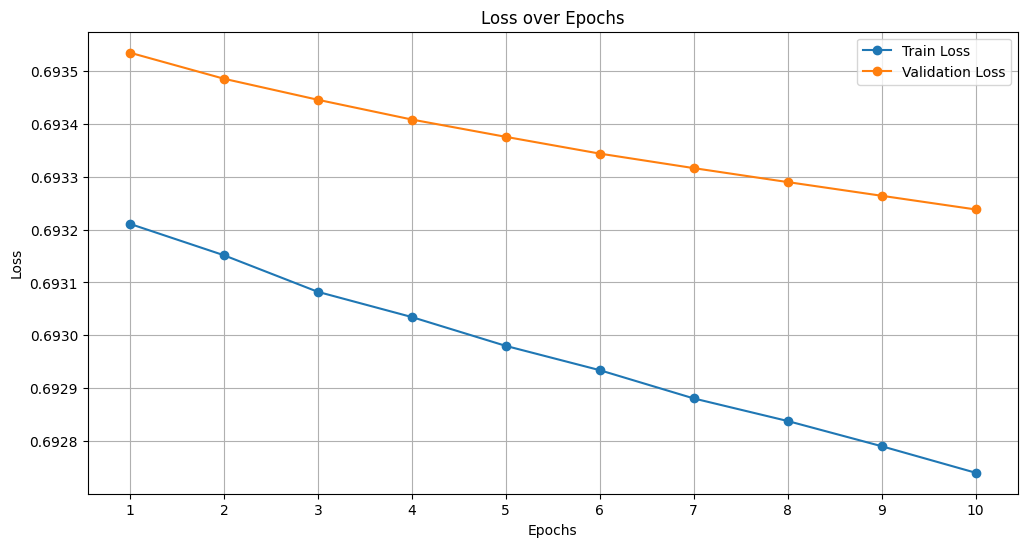

In [ ]:
epochs = list(range(1, N_EPOCHS + 1))

# Plot Loss
plot_metrics(epochs, Loss_Train.values(), Loss_val.values(), 'Loss')

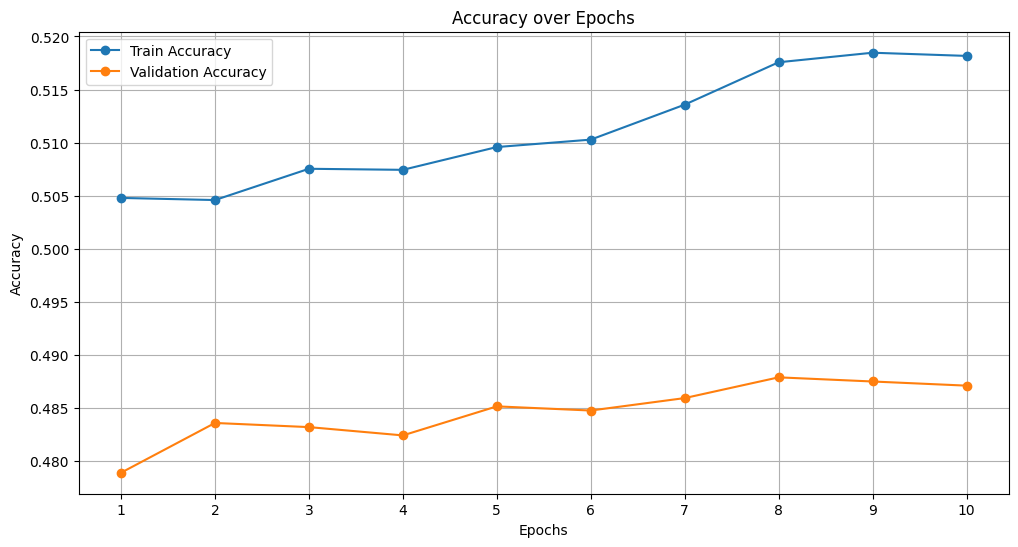

In [ ]:
plot_metrics(epochs, Accuracy_Train.values(), Accuracy_val.values(), 'Accuracy')

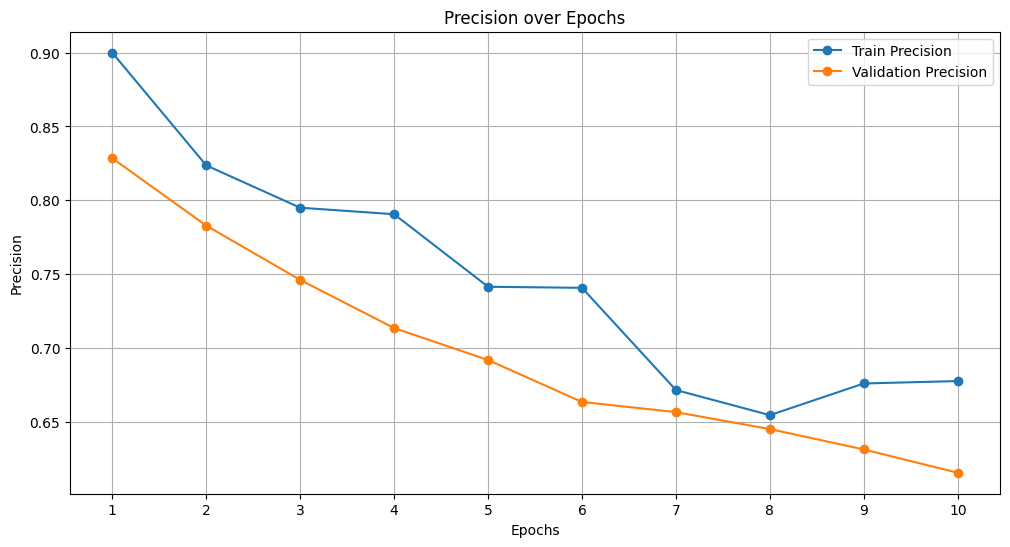

In [ ]:
plot_metrics(epochs, Precision_Train.values(), Precision_val.values(), 'Precision')

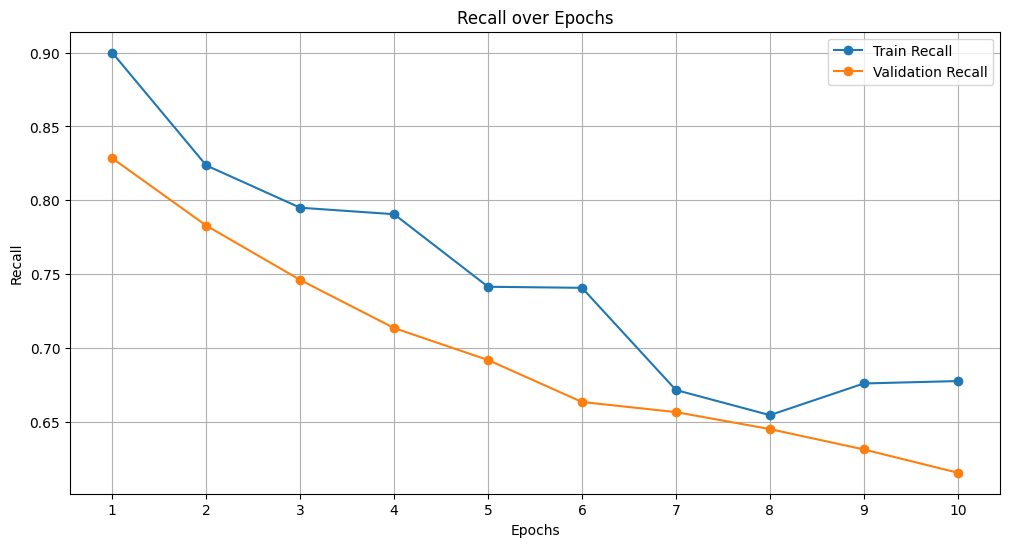

In [ ]:
plot_metrics(epochs, Recall_Train.values(), Recall_val.values(), 'Recall')

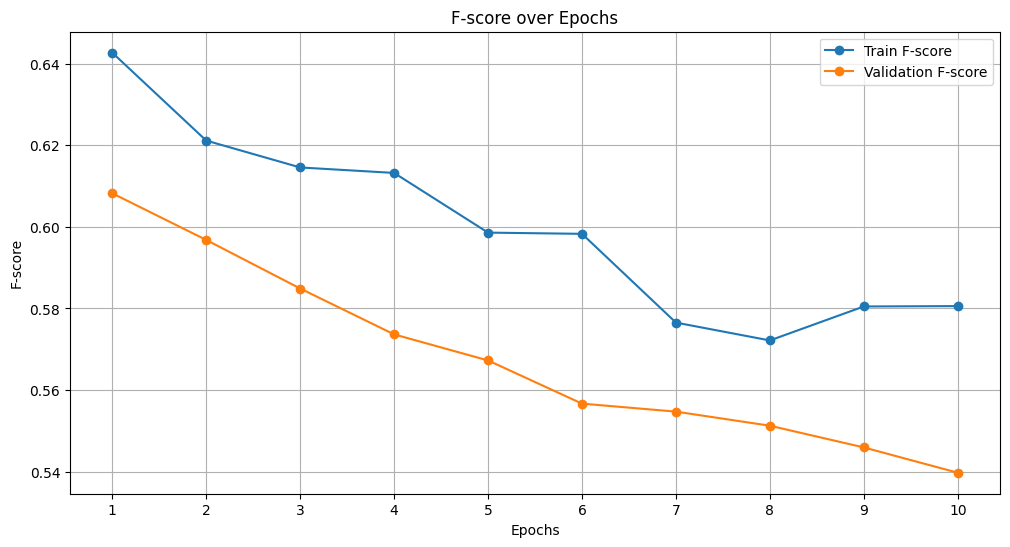

In [ ]:
plot_metrics(epochs, F_scores_Train.values(), F_scores_val.values(), 'F-score')

### **Testing :**

In [ ]:

model.load_state_dict(torch.load('tut1-model.pt'))

test_loss, test_acc, test_precision, test_recall, test_fscore = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% | Test Precision: {test_precision:.3f} | Test Recall: {test_recall:.3f} | Test F1-Score: {test_fscore:.3f}')

<ipython-input-40-7f2c6be7503e>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('tut1-model.pt'))


Test Loss: 0.693 | Test Acc: 50.27% | Test Precision: 0.610 | Test Recall: 0.610 | Test F1-Score: 0.547


# **FFN for binary classification :**

## **Model class :**

In [ ]:
class FFN_binary(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super().__init__()
        self.input_dim = input_dim
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, output_dim)
        self.relu = nn.ReLU()

    def forward(self, text, text_lengths):
        one_hot = self.one_hot_encode(text)
        one_hot = one_hot.sum(dim=1)
        x = self.fc1(one_hot)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        return self.fc3(x)

    def one_hot_encode(self, text):
        batch_size, sent_len = text.shape
        device = text.device
        one_hot = torch.zeros(batch_size, sent_len, self.input_dim, device=device)
        one_hot.scatter_(2, text.unsqueeze(2), 1)
        return one_hot

## **Model Decleration :**

In [ ]:
INPUT_DIM = len(TEXT.vocab)
HIDDEN_DIM1 = 256
HIDDEN_DIM2 = 128
OUTPUT_DIM = 1

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

model = FFN_binary(INPUT_DIM, HIDDEN_DIM1, HIDDEN_DIM2, OUTPUT_DIM)
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
criterion = criterion.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

The model has 322,817 trainable parameters


## **Training and evaluation functions:**

In [ ]:
# train loop
def train(model, iterator, optimizer, criterion):

    epoch_loss = 0
    epoch_acc = 0
    epoch_recall = 0
    epoch_precision = 0
    epoch_Fscore = 0
    model.train()

    for batch in iterator:

        optimizer.zero_grad()

        text, text_lengths = batch.text
        labels = batch.label.float()
        text_lengths = text_lengths.cpu()
        predictions = model(text, text_lengths).squeeze(1)
        # predictions = model(batch.text).squeeze(1)

        loss = criterion(predictions, labels)

        acc = binary_accuracy(predictions, labels)

        precision = binary_recall(predictions, labels)

        recall = binary_recall(predictions, labels)

        Fscore = binary_fscore(predictions, labels)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_precision += precision.item()
        epoch_recall += recall.item()
        epoch_Fscore += Fscore.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_precision/len(iterator), epoch_recall/len(iterator), epoch_Fscore/len(iterator)


# eval loop
def evaluate(model, iterator, criterion):

    epoch_loss = 0
    epoch_acc = 0
    epoch_recall = 0
    epoch_precision = 0
    epoch_Fscore = 0


    model.eval()

    with torch.no_grad():

        for batch in iterator:

            text, text_lengths = batch.text  # Unpacking the padded text and its lengths
            text_lengths = text_lengths.cpu()
            predictions = model(text, text_lengths).squeeze(1)

            # predictions = model(batch.text).squeeze(1)
            labels = batch.label.float()
            loss = criterion(predictions, batch.label)

            acc = binary_accuracy(predictions, labels)

            precision = binary_recall(predictions, labels)

            recall = binary_recall(predictions, labels)

            Fscore = binary_fscore(predictions, labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_precision += precision.item()
            epoch_recall += recall.item()
            epoch_Fscore += Fscore.item()


    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_precision/len(iterator), epoch_recall/len(iterator), epoch_Fscore/len(iterator)


## **Training :**

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 10

best_valid_loss = float('inf')

# Initialize dictionaries to store metrics
F_scores_Train = {}
Accuracy_Train = {}
Precision_Train = {}
Recall_Train = {}
Loss_Train = {}

F_scores_val = {}
Accuracy_val = {}
Precision_val = {}
Recall_val = {}
Loss_val = {}


for epoch in range(N_EPOCHS):
    start_time = time.time()

    # Train the model
    train_loss, train_acc, train_precision, train_recall, train_fscore = train(model, train_iterator, optimizer, criterion)

    # Evaluate the model
    valid_loss, valid_acc, valid_precision, valid_recall, valid_fscore = evaluate(model, valid_iterator, criterion)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # Save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'ffn-model-binary.pt')

    # Store metrics for training
    Accuracy_Train[epoch + 1] = train_acc
    Precision_Train[epoch + 1] = train_precision
    Recall_Train[epoch + 1] = train_recall
    F_scores_Train[epoch + 1] = train_fscore
    Loss_Train[epoch + 1] = train_loss

    # Store metrics for validation
    Accuracy_val[epoch + 1] = valid_acc
    Precision_val[epoch + 1] = valid_precision
    Recall_val[epoch + 1] = valid_recall
    F_scores_val[epoch + 1] = valid_fscore
    Loss_val[epoch + 1] = valid_loss

    # Print metrics
    print(f'Epoch: {epoch + 1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc * 100:.2f}%')


Epoch: 01 | Epoch Time: 0m 6s
	Train Loss: 0.593 | Train Acc: 71.43%
	 Val. Loss: 0.457 |  Val. Acc: 83.71%
Epoch: 02 | Epoch Time: 0m 4s
	Train Loss: 0.379 | Train Acc: 83.21%
	 Val. Loss: 0.425 |  Val. Acc: 86.17%
Epoch: 03 | Epoch Time: 0m 5s
	Train Loss: 0.341 | Train Acc: 85.44%
	 Val. Loss: 0.412 |  Val. Acc: 86.05%
Epoch: 04 | Epoch Time: 0m 5s
	Train Loss: 0.338 | Train Acc: 85.48%
	 Val. Loss: 0.398 |  Val. Acc: 86.25%
Epoch: 05 | Epoch Time: 0m 4s
	Train Loss: 0.323 | Train Acc: 86.38%
	 Val. Loss: 0.401 |  Val. Acc: 83.59%
Epoch: 06 | Epoch Time: 0m 7s
	Train Loss: 0.315 | Train Acc: 86.85%
	 Val. Loss: 0.359 |  Val. Acc: 85.74%
Epoch: 07 | Epoch Time: 0m 10s
	Train Loss: 0.315 | Train Acc: 86.45%
	 Val. Loss: 0.358 |  Val. Acc: 85.78%
Epoch: 08 | Epoch Time: 0m 7s
	Train Loss: 0.331 | Train Acc: 85.94%
	 Val. Loss: 0.370 |  Val. Acc: 84.69%
Epoch: 09 | Epoch Time: 0m 10s
	Train Loss: 0.317 | Train Acc: 86.65%
	 Val. Loss: 0.350 |  Val. Acc: 84.84%
Epoch: 10 | Epoch Time: 0m

## **Plots :**

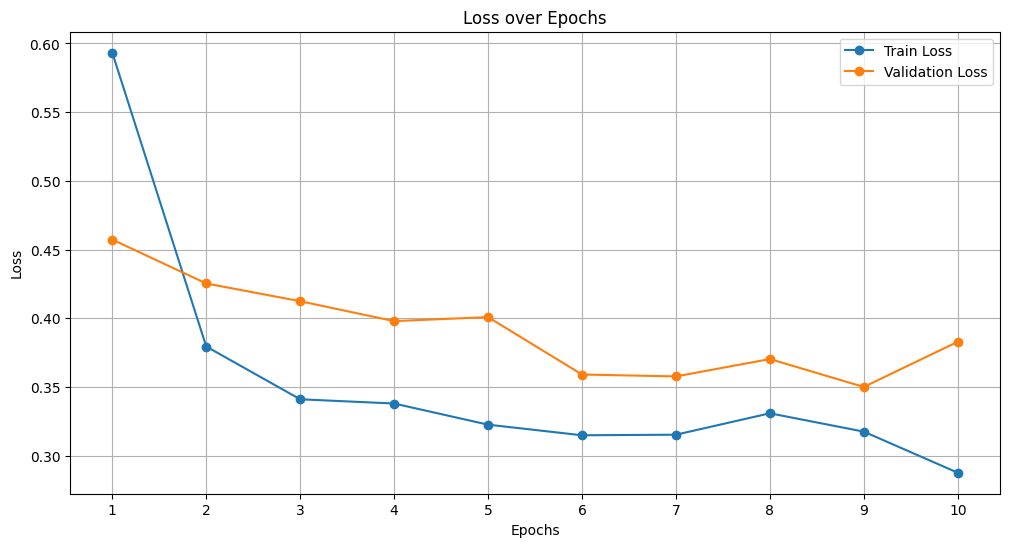

In [ ]:
epochs = list(range(1, N_EPOCHS + 1))

# Plot Loss
plot_metrics(epochs, Loss_Train.values(), Loss_val.values(), 'Loss')

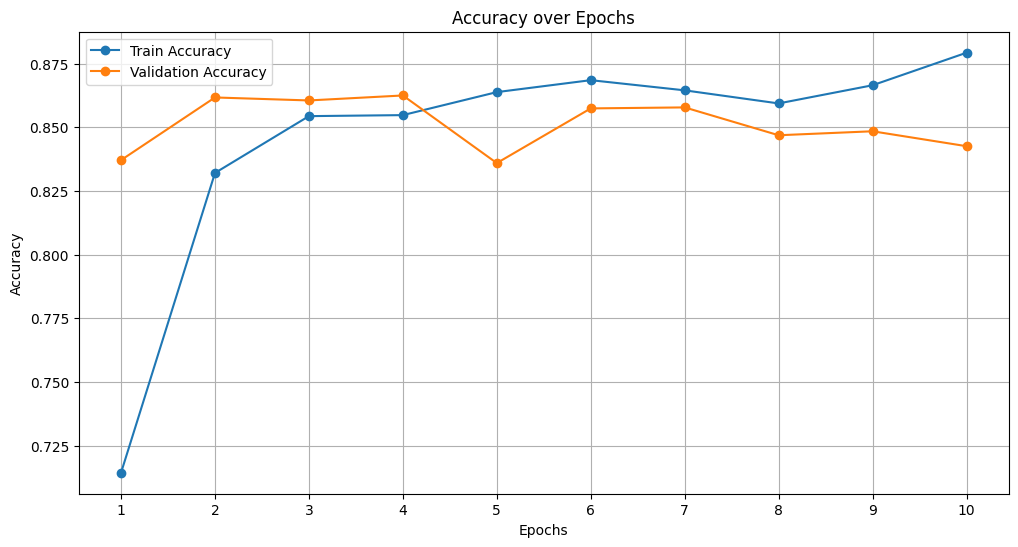

In [ ]:
plot_metrics(epochs, Accuracy_Train.values(), Accuracy_val.values(), 'Accuracy')

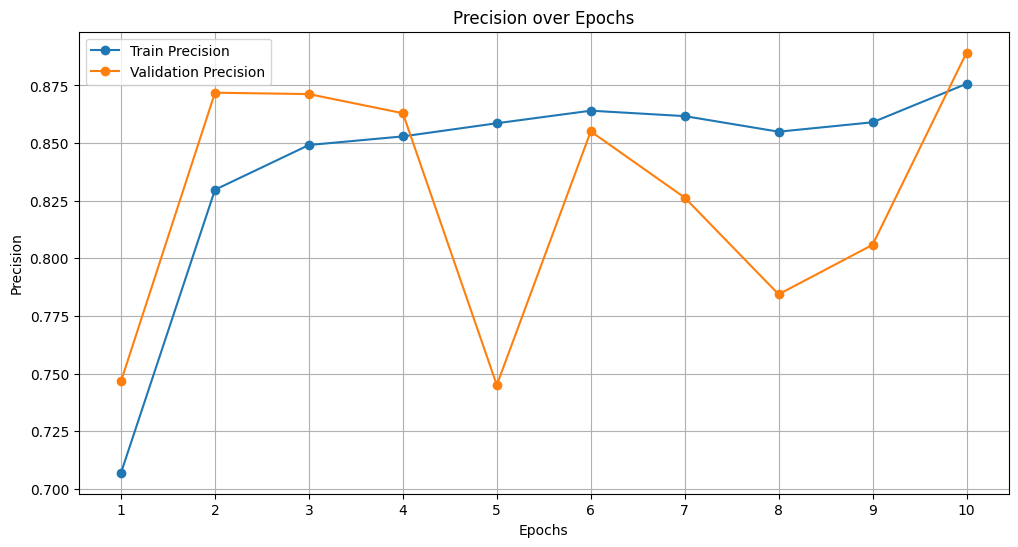

In [ ]:
plot_metrics(epochs, Precision_Train.values(), Precision_val.values(), 'Precision')

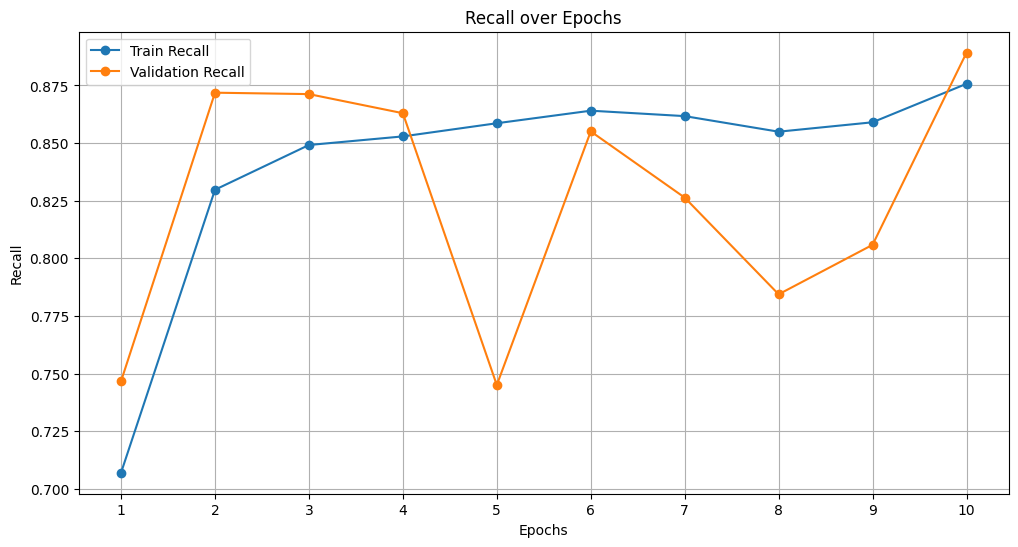

In [ ]:
plot_metrics(epochs, Recall_Train.values(), Recall_val.values(), 'Recall')

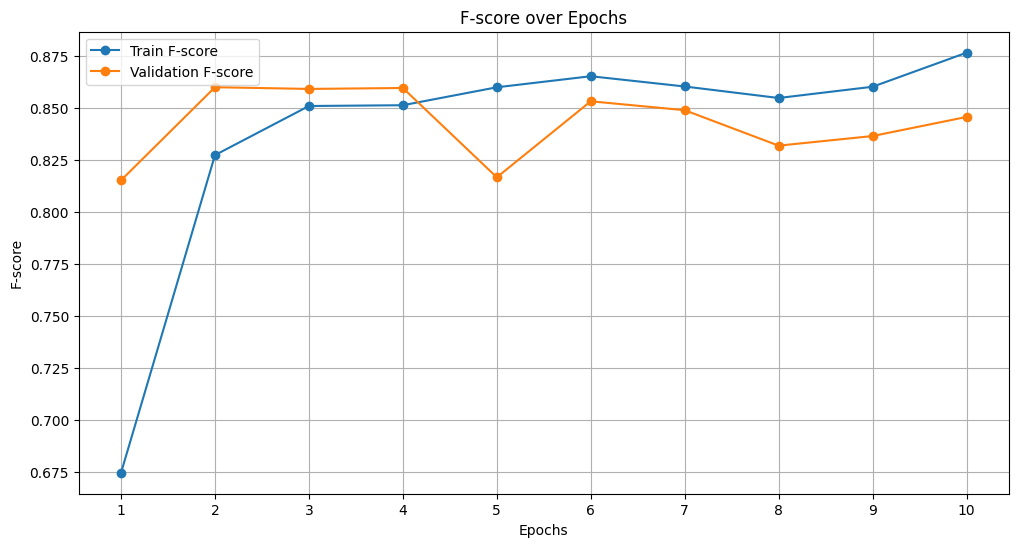

In [ ]:
plot_metrics(epochs, F_scores_Train.values(), F_scores_val.values(), 'F-score')

## **Testing :**

In [ ]:
model.load_state_dict(torch.load('ffn-model-binary.pt'))
test_loss, test_acc, test_precision, test_recall, test_fscore = evaluate(model, test_iterator, criterion)
test_loss, test_acc, test_precision, test_recall, test_fscore = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% | Test Precision: {test_precision:.3f} | Test Recall: {test_recall:.3f} | Test F1-Score: {test_fscore:.3f}')



<ipython-input-51-35c83918f5c1>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('ffn-model-binary.pt'))


Test Loss: 0.387 | Test Acc: 83.59% | Test Precision: 0.807 | Test Recall: 0.807 | Test F1-Score: 0.829


# **Part 2 : MULTICLASS CLASSIFICATION { SEMVAL DATASET }**


## **Dataset Preprocessing :**

In [ ]:
kp = pd.read_csv('/content/semeval-2013-train-all.csv', on_bad_lines='skip')

In [ ]:
kp = kp.rename(columns={'label\ttext': 'mashed_column'})


#print(kp.columns)
# Split the mashed column into 'label' and 'text'
kp[['label', 'text']] = kp['mashed_column'].str.split('\t',n=1, expand=True)
kp = kp.drop(columns=['mashed_column'])

In [ ]:
kp.head()

,label,text
0,1,One Night like In Vegas I make dat Nigga Famous
1,1,Walking through Chelsea at this time of day is...
2,-1,looking at the temp outside....hpw did it get ...
3,-1,I'm stuck in London again... :( I don't wanna ...
4,1,It's 2.32 a.m. here in Italy now :) Tomorrow o...


In [ ]:
semval_train = kp.sample(frac=1).reset_index(drop=True)

In [ ]:
X = kp['text']
y = kp['label']


X_train, X_val, y_train, y_val = tts(X, y, test_size=0.2, random_state=42)


semval_train_data = pd.DataFrame({'text': X_train, 'label': y_train})
semval_val_data = pd.DataFrame({'text': X_val, 'label': y_val})


In [ ]:
semval_train_data = semval_train_data.reset_index(drop=True)
semval_train_data['label'] = semval_train_data['label'].astype(int)
semval_train_data.head()

,text,label
0,The earth is run by psychopathsKids could be e...,-1
1,@StarfmZimbabwe News from the US The statues o...,-1
2,Real committed to watch Netflix all day Wednesday,1
3,yo I'm excited for Royal Rumble might book tha...,1
4,They're showing the Motown 25th on PBS. Michae...,1


In [ ]:
semval_val_data = semval_val_data.reset_index(drop=True)

semval_val_data['label'] = semval_val_data['label'].astype(int)
semval_val_data.head()

,text,label
0,Fidel Castro must of had information on the Cl...,0
1,Just a typical Friday night spent @ TGIF w/ th...,1
2,Paul Dunne is Irish not British. I guess BBC w...,-1
3,@CR2News Demi is performing at the Houston Rod...,0
4,Saturday kitchen the moment Chris Evans ruins ...,-1


In [ ]:
semval_test = pd.read_csv('/content/semeval-2013-dev.csv', on_bad_lines='skip')

In [ ]:
semval_test = semval_test.rename(columns={'label\ttext': 'mashed_column'})


#print(kp.columns)
# Split the mashed column into 'label' and 'text'
semval_test[['label', 'text']] = semval_test['mashed_column'].str.split('\t',n=1, expand=True)
semval_test_data = semval_test.drop(columns=['mashed_column'])
semval_test_data = semval_test_data[['text', 'label']]
semval_test_data['label'] = semval_test_data['label'].astype(int)

In [ ]:
semval_test_data.head()

,text,label
0,Watching Devil Inside for the 1st time tonight...,0
1,Off to do my vlog. Watching Devil Inside and J...,0
2,@raykipo take Silver at the Hib cup. Great day...,1
3,@hollyhippo I'm going to blockbuster tomorrow ...,0
4,Watching Devil Inside for the 2nd time and I'm...,0


In [ ]:
semval_train_data.to_csv('semval_train_df.csv')
semval_test_data.to_csv('semval_test_df.csv')
semval_val_data.to_csv('semval_valid_df.csv')

## **Input features and tokenization :**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

spacy_en = spacy.load("en_core_web_sm")

def tokenize(text):
  return [tok.text for tok in spacy_en.tokenizer(text)]

# create fields
# TEXT = data.Field(sequential = True, use_vocab = True, tokenize = tokenize)
# LABEL = data.LabelField(dtype = torch.float)

TEXT = data.Field(sequential=True, use_vocab=True, tokenize=tokenize,
                  include_lengths=True, batch_first=True, pad_token='<pad>')
LABEL = data.LabelField(dtype=torch.float)

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [ ]:
Fields = [(None, None),('text', TEXT),('label', LABEL) ]

semval_tr_data , semval_va_data, semval_tes_data = data.TabularDataset.splits( path = '/content',train = 'semval_train_df.csv',validation= 'semval_valid_df.csv',
      test = 'semval_test_df.csv',
      format = 'csv',
      fields = Fields,
      skip_header = True)



In [ ]:
print(vars(semval_tr_data[0]))

{'text': ['The', 'earth', 'is', 'run', 'by', 'psychopathsKids', 'could', 'be', 'exposed', 'to', 'this#pornharms', '#', 'draintheswamp', 'https://t.co/m3RUDsWS8s'], 'label': '-1'}


In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(val_data)}')
print(f'Number of testing examples: {len(test_data)}')

def sort_key(ex):
    return len(ex.text)

TEXT.build_vocab(semval_tr_data, max_size = 1000)
LABEL.build_vocab(semval_tr_data)

print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

BATCH_SIZE = 64

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (semval_tr_data, semval_va_data, semval_tes_data),
    batch_size=BATCH_SIZE,
    sort_within_batch=True,  # Sort within batches to minimize padding
    sort_key=lambda x: len(x.text),  # Sort by text length
    device=device)

Number of training examples: 20000
Number of validation examples: 2500
Number of testing examples: 2500
Unique tokens in TEXT vocabulary: 1002
Unique tokens in LABEL vocabulary: 3


# **RNN for Multi-class classification :**

## **Model class :**

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        # The RNN layer
        self.rnn = nn.RNN(input_dim, hidden_dim,batch_first=True)  # input_dim is now the vocabulary size

        # The linear layer
        self.fc = nn.Linear(hidden_dim, output_dim)


    #     return one_hot.permute(1, 0, 2)  #
    def forward(self, text, text_lengths):
        # text = [batch size, sent len]

        # Create one-hot encoding
        one_hot = self.one_hot_encode(text)

        # one_hot = [batch size, sent len, input_dim]
        packed_input = nn.utils.rnn.pack_padded_sequence(one_hot, text_lengths, batch_first=True, enforce_sorted=False)

        # Forward pass through RNN
        packed_output, hidden = self.rnn(packed_input)

        # Unpack the output (only needed if you want the sequence outputs)
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)

        # Use the last hidden state
        return self.fc(hidden.squeeze(0))

    def one_hot_encode(self, text):
        batch_size, sent_len = text.shape
        device = text.device

        # Create a tensor of zeros for one-hot encoding on the same device as the input
        one_hot = torch.zeros(batch_size, sent_len, self.input_dim, device=device)  # [batch size, sent len, vocab size]

        # Set the appropriate indices to 1 (scatter along the last dimension)
        one_hot.scatter_(2, text.unsqueeze(2), 1)  # Reshape and scatter the one-hot indices

        return one_hot  # Keep it as is for RNN input



## **Model Declaration :**

In [ ]:

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 1000
HIDDEN_DIM = 256
OUTPUT_DIM = 3

# model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)
model = RNN(INPUT_DIM,HIDDEN_DIM, OUTPUT_DIM)
# parameter count
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

# optimizer and loss function
optimizer = optim.SGD(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# put the model and loss function on 'device'
model = model.to(device)
criterion = criterion.to(device)

The model has 323,331 trainable parameters


## **Metrics calculation functions for Multi-class classification :**

In [ ]:
def multi_class_accuracy(preds, y):

    max_preds = preds.argmax(dim=1, keepdim=True)  # Get the index of the max probability
    correct = max_preds.squeeze(1).eq(y)  # Compare to the true labels
    acc = correct.sum() / len(correct)
    return acc

def multi_class_recall(preds, y):

    max_preds = preds.argmax(dim=1, keepdim=True)  # Get predicted classes
    true_positives = (max_preds.squeeze(1) == y).float().sum()
    false_negatives = (y != max_preds.squeeze(1)).float().sum()
    recall = true_positives / (true_positives + false_negatives + 1e-6)  # Avoid division by zero
    return recall

def multi_class_precision(preds, y):

    max_preds = preds.argmax(dim=1, keepdim=True)  # Get predicted classes
    true_positives = (max_preds.squeeze(1) == y).float().sum()
    false_positives = (y != max_preds.squeeze(1)).float().sum()
    precision = true_positives / (true_positives + false_positives + 1e-6)  # Avoid division by zero
    return precision

def multi_class_fscore(preds, y):

    precision = multi_class_precision(preds, y)
    recall = multi_class_recall(preds, y)
    fscore = 2 * (precision * recall) / (precision + recall + 1e-6)  # F1 score
    return fscore


## **Training and evaluation functions:**

In [ ]:

def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    epoch_recall = 0
    epoch_precision = 0
    epoch_Fscore = 0
    model.train()

    for batch in iterator:
        optimizer.zero_grad()

        # Unpack text and lengths
        text, text_lengths = batch.text  # Unpacking the padded text and its lengths
        labels = batch.label.long()
        text_lengths = text_lengths.cpu()
        predictions = model(text, text_lengths)  # Pass both text and lengths

        loss = criterion(predictions, labels)

        acc = multi_class_accuracy(predictions, labels)
        precision = multi_class_precision(predictions, labels)
        recall = multi_class_recall(predictions, labels)
        Fscore = multi_class_fscore(predictions, labels)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_precision += precision.item()
        epoch_recall += recall.item()
        epoch_Fscore += Fscore.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_precision / len(iterator), epoch_recall / len(iterator), epoch_Fscore / len(iterator)

def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    epoch_recall = 0
    epoch_precision = 0
    epoch_Fscore = 0

    model.eval()

    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text  # Unpacking the padded text and its lengths
            text_lengths = text_lengths.cpu()
            predictions = model(text, text_lengths)  # Pass both text and lengths

            labels = batch.label.long()
            loss = criterion(predictions, labels)

            acc = multi_class_accuracy(predictions, labels)
            precision = multi_class_precision(predictions, labels)
            recall = multi_class_recall(predictions, labels)
            Fscore = multi_class_fscore(predictions, labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_precision += precision.item()
            epoch_recall += recall.item()
            epoch_Fscore += Fscore.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_precision / len(iterator), epoch_recall / len(iterator), epoch_Fscore / len(iterator)


## **Training :**

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 10

best_valid_loss = float('inf')

F_scores_Train = {}
Accuracy_Train = {}
Precision_Train = {}
Recall_Train = {}
Loss_Train = {}

F_scores_val = {}
Accuracy_val = {}
Precision_val = {}
Recall_val = {}
Loss_val = {}

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss, train_acc, train_precision, train_recall, train_Fscore = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc, valid_precision, valid_recall, valid_Fscore = evaluate(model, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')

    Accuracy_Train[epoch+1] = train_acc
    Precision_Train[epoch+1] = train_precision
    Recall_Train[epoch+1] = train_recall
    F_scores_Train[epoch+1] = train_Fscore
    Loss_Train[epoch+1] = train_loss

    Accuracy_val[epoch+1] = valid_acc
    Precision_val[epoch+1] = valid_precision
    Recall_val[epoch+1] = valid_recall
    F_scores_val[epoch+1] = valid_Fscore
    Loss_val[epoch+1] = valid_loss

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 2s
	Train Loss: 1.074 | Train Acc: 44.67%
	 Val. Loss: 1.056 |  Val. Acc: 45.57%
Epoch: 02 | Epoch Time: 0m 2s
	Train Loss: 1.048 | Train Acc: 45.75%
	 Val. Loss: 1.042 |  Val. Acc: 45.57%
Epoch: 03 | Epoch Time: 0m 3s
	Train Loss: 1.040 | Train Acc: 45.74%
	 Val. Loss: 1.038 |  Val. Acc: 45.57%
Epoch: 04 | Epoch Time: 0m 2s
	Train Loss: 1.038 | Train Acc: 45.73%
	 Val. Loss: 1.036 |  Val. Acc: 45.57%
Epoch: 05 | Epoch Time: 0m 2s
	Train Loss: 1.037 | Train Acc: 45.73%
	 Val. Loss: 1.036 |  Val. Acc: 45.57%
Epoch: 06 | Epoch Time: 0m 2s
	Train Loss: 1.036 | Train Acc: 45.73%
	 Val. Loss: 1.036 |  Val. Acc: 45.57%
Epoch: 07 | Epoch Time: 0m 2s
	Train Loss: 1.036 | Train Acc: 45.72%
	 Val. Loss: 1.035 |  Val. Acc: 45.57%
Epoch: 08 | Epoch Time: 0m 2s
	Train Loss: 1.036 | Train Acc: 45.74%
	 Val. Loss: 1.035 |  Val. Acc: 45.57%
Epoch: 09 | Epoch Time: 0m 2s
	Train Loss: 1.035 | Train Acc: 45.74%
	 Val. Loss: 1.035 |  Val. Acc: 45.57%
Epoch: 10 | Epoch Time: 0m 2

## **Plots :**

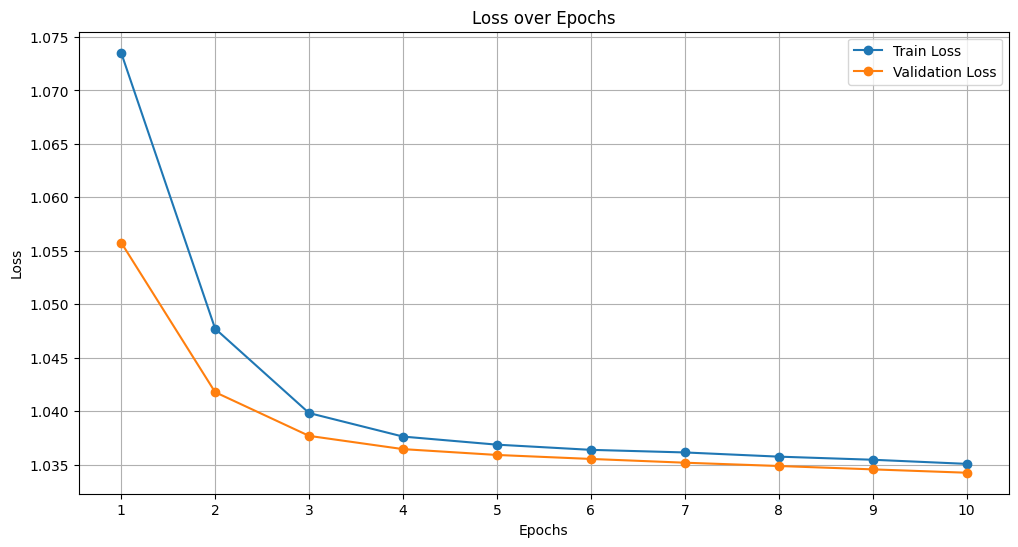

In [ ]:
epochs = list(range(1, N_EPOCHS + 1))

# Plot Loss
plot_metrics(epochs, Loss_Train.values(), Loss_val.values(), 'Loss')

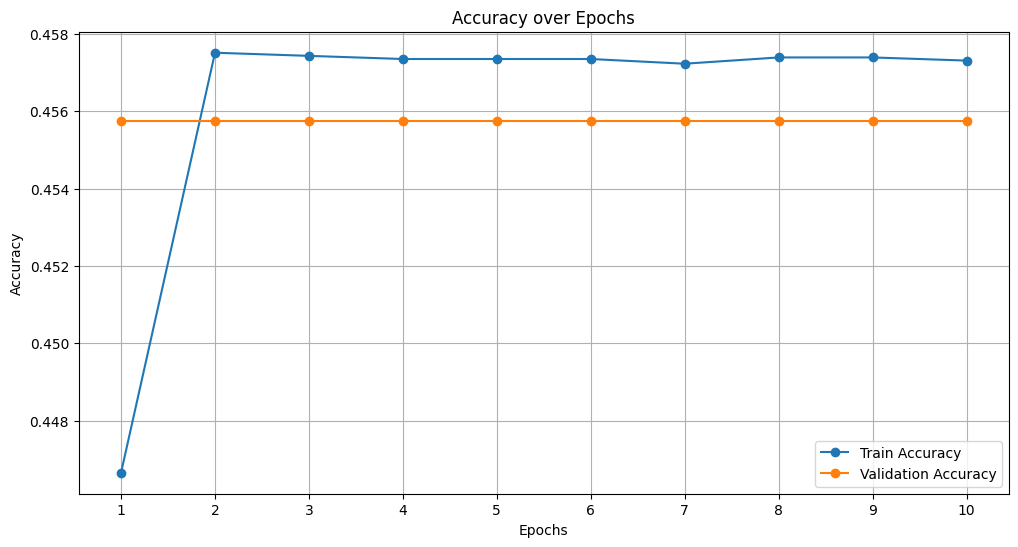

In [ ]:
plot_metrics(epochs, Accuracy_Train.values(), Accuracy_val.values(), 'Accuracy')

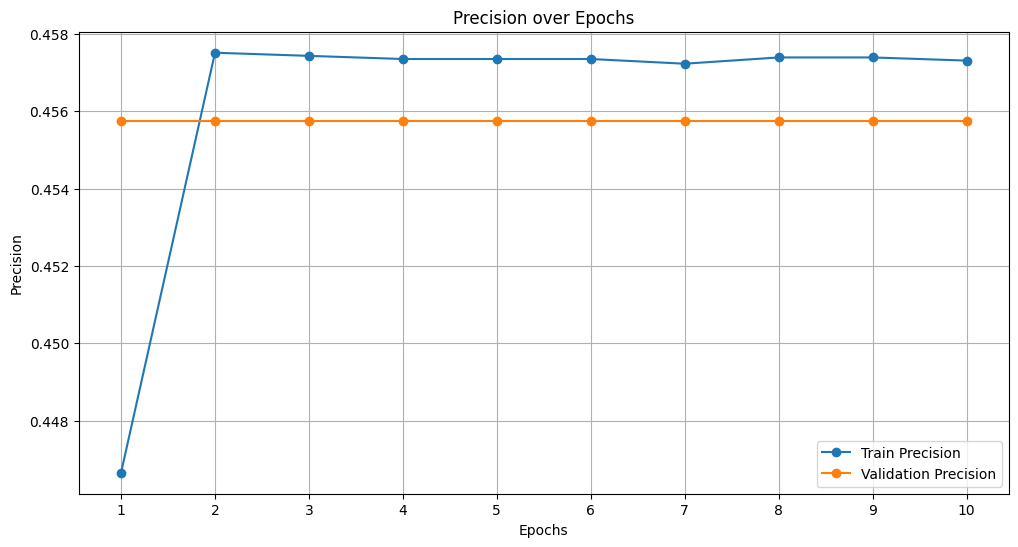

In [ ]:
plot_metrics(epochs, Precision_Train.values(), Precision_val.values(), 'Precision')

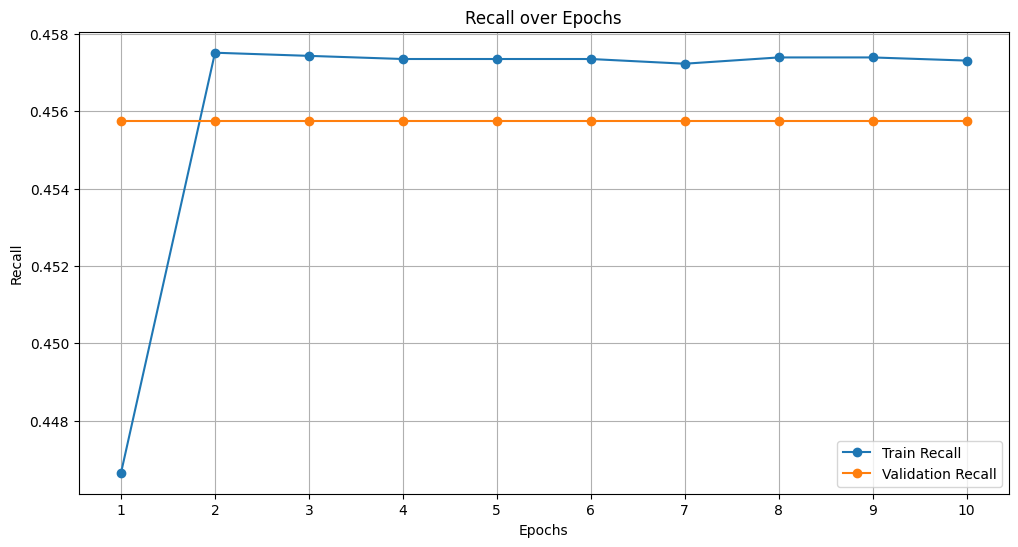

In [ ]:
plot_metrics(epochs, Recall_Train.values(), Recall_val.values(), 'Recall')

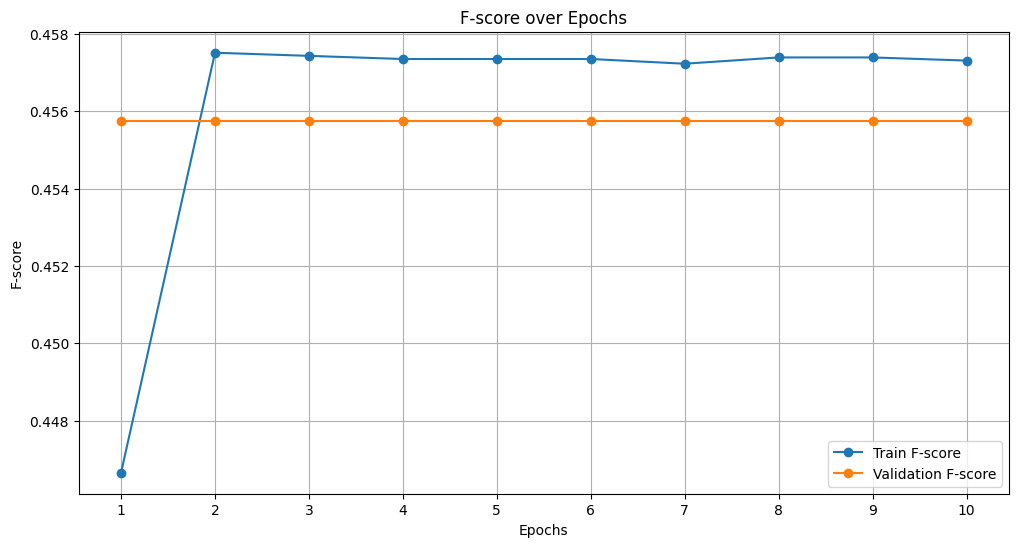

In [ ]:
plot_metrics(epochs, F_scores_Train.values(), F_scores_val.values(), 'F-score')

## **Testing :**

In [ ]:
model.load_state_dict(torch.load('tut2-model.pt'))

test_loss, test_acc, test_precision, test_recall, test_fscore = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% | Test Precision: {test_precision:.3f} | Test Recall: {test_recall:.3f} | Test F1-Score: {test_fscore:.3f}')


Test Loss: 1.054 | Test Acc: 44.17% | Test Precision: 0.442 | Test Recall: 0.442 | Test F1-Score: 0.442


<ipython-input-104-83974005bf18>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('tut2-model.pt'))


# **FFN for Multi-class classification :**



## **Model class :**

In [ ]:
class FFN_multiclass(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super().__init__()
        self.input_dim = input_dim  # Store input dimension
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, output_dim)
        self.relu = nn.ReLU()

    def forward(self, text, text_lengths):
        # One-hot encode the input text
        one_hot = self.one_hot_encode(text)

        # Sum over the sequence length to ignore padding
        one_hot = one_hot.sum(dim=1)  # Sum along the sequence dimension

        # Pass through the network
        x = self.fc1(one_hot)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        return self.fc3(x)

    def one_hot_encode(self, text):
        batch_size, sent_len = text.shape
        device = text.device
        one_hot = torch.zeros(batch_size, sent_len, self.input_dim, device=device)
        one_hot.scatter_(2, text.unsqueeze(2), 1)
        return one_hot

## **Model declaration**

In [ ]:
INPUT_DIM = len(TEXT.vocab)  # Vocabulary size
HIDDEN_DIM1 = 256
HIDDEN_DIM2 = 128
OUTPUT_DIM = 3  # Number of classes

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

model = FFN_multiclass(INPUT_DIM, HIDDEN_DIM1, HIDDEN_DIM2, OUTPUT_DIM)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
# Use an optimizer (SGD, Adam, etc.)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

The model has 323,331 trainable parameters


## **Training and evaluation functions:**

In [ ]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    epoch_recall = 0
    epoch_precision = 0
    epoch_Fscore = 0

    model.train()

    for batch in iterator:
        optimizer.zero_grad()

        text, text_lengths = batch.text  # Unpack text and lengths
        labels = batch.label.to(device).long()

        # Predictions
        predictions = model(text, text_lengths)

        # Calculate loss
        loss = criterion(predictions, labels)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        acc = multi_class_accuracy(predictions, labels)
        precision = multi_class_precision(predictions, labels)
        recall = multi_class_recall(predictions, labels)
        Fscore = multi_class_fscore(predictions, labels)

        # Accumulate the metrics for the epoch
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_precision += precision.item()
        epoch_recall += recall.item()
        epoch_Fscore += Fscore.item()

    return (epoch_loss / len(iterator),
            epoch_acc / len(iterator),
            epoch_precision / len(iterator),
            epoch_recall / len(iterator),
            epoch_Fscore / len(iterator))


In [ ]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    epoch_recall = 0
    epoch_precision = 0
    epoch_Fscore = 0

    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():  # Disable gradient calculation
        for batch in iterator:
            # Unpack the text and labels from the batch
            text, text_lengths = batch.text  # Unpack text and lengths
            labels = batch.label.to(device).long()
            # text, labels = batch.text, batch.label.long()

            # Forward pass: get predictions from the model
            predictions = model(text,text_lengths)

            # Compute the loss
            loss = criterion(predictions, labels)

            # Calculate metrics
            acc = multi_class_accuracy(predictions, labels)
            precision = multi_class_precision(predictions, labels)
            recall = multi_class_recall(predictions, labels)
            Fscore = multi_class_fscore(predictions, labels)

            # Accumulate the metrics for the epoch
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_precision += precision.item()
            epoch_recall += recall.item()
            epoch_Fscore += Fscore.item()

    # Average the accumulated metrics over the number of batches
    return (epoch_loss / len(iterator),
            epoch_acc / len(iterator),
            epoch_precision / len(iterator),
            epoch_recall / len(iterator),
            epoch_Fscore / len(iterator))


## **Metrics calculation functions for Multi-class classification :**

In [ ]:
def categorical_accuracy(preds, y):

    max_preds = preds.argmax(dim=1, keepdim=True)  # Get the index of the max logit
    correct = max_preds.squeeze(1).eq(y)
    return correct.sum() / torch.FloatTensor([y.shape[0]])

def multi_class_precision(preds, y, average='macro'):

    max_preds = preds.argmax(dim=1, keepdim=True).squeeze(1)  # Get the predicted class
    true_positives = (max_preds == y).float()
    false_positives = (max_preds != y).float()

    class_precision = []
    for class_index in range(preds.size(1)):  # preds.size(1) is the number of classes
        tp = (true_positives[y == class_index].sum())
        fp = (false_positives[max_preds == class_index].sum())
        precision = tp / (tp + fp + 1e-10)  # Add a small value to avoid division by zero
        class_precision.append(precision)

    if average == 'macro':
        return torch.mean(torch.stack(class_precision))
    elif average == 'micro':
        return true_positives.sum() / (true_positives.sum() + false_positives.sum())

def multi_class_recall(preds, y, average='macro'):

    max_preds = preds.argmax(dim=1, keepdim=True).squeeze(1)
    true_positives = (max_preds == y).float()
    false_negatives = (max_preds != y).float()

    class_recall = []
    for class_index in range(preds.size(1)):
        tp = (true_positives[y == class_index].sum())
        fn = (false_negatives[y == class_index].sum())
        recall = tp / (tp + fn + 1e-10)
        class_recall.append(recall)

    if average == 'macro':
        return torch.mean(torch.stack(class_recall))
    elif average == 'micro':
        return true_positives.sum() / (true_positives.sum() + false_negatives.sum())

def multi_class_fscore(preds, y, average='macro'):

    precision = multi_class_precision(preds, y, average=average)
    recall = multi_class_recall(preds, y, average=average)

    f1 = 2 * (precision * recall) / (precision + recall + 1e-10)  # Harmonic mean

    return f1


## **Training :**

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:

N_EPOCHS = 10

best_valid_loss = float('inf')

# Initialize dictionaries to store metrics
F_scores_Train = {}
Accuracy_Train = {}
Precision_Train = {}
Recall_Train = {}
Loss_Train = {}

F_scores_val = {}
Accuracy_val = {}
Precision_val = {}
Recall_val = {}
Loss_val = {}


for epoch in range(N_EPOCHS):
    start_time = time.time()

    # Train the model
    train_loss, train_acc, train_precision, train_recall, train_fscore = train(model, train_iterator, optimizer, criterion)

    # Evaluate the model
    valid_loss, valid_acc, valid_precision, valid_recall, valid_fscore = evaluate(model, valid_iterator, criterion)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    # Calculate elapsed time
    #epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # Save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'ffn-model.pt')

    # Store metrics for training
    Accuracy_Train[epoch + 1] = train_acc
    Precision_Train[epoch + 1] = train_precision
    Recall_Train[epoch + 1] = train_recall
    F_scores_Train[epoch + 1] = train_fscore
    Loss_Train[epoch + 1] = train_loss

    # Store metrics for validation
    Accuracy_val[epoch + 1] = valid_acc
    Precision_val[epoch + 1] = valid_precision
    Recall_val[epoch + 1] = valid_recall
    F_scores_val[epoch + 1] = valid_fscore
    Loss_val[epoch + 1] = valid_loss

    # Print metrics
    print(f'Epoch: {epoch + 1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc * 100:.2f}%')


Epoch: 01 | Epoch Time: 0m 4s
	Train Loss: 1.746 | Train Acc: 58.53%
	 Val. Loss: 0.832 |  Val. Acc: 62.11%
Epoch: 02 | Epoch Time: 0m 3s
	Train Loss: 1.551 | Train Acc: 64.56%
	 Val. Loss: 0.819 |  Val. Acc: 62.65%
Epoch: 03 | Epoch Time: 0m 3s
	Train Loss: 1.408 | Train Acc: 68.77%
	 Val. Loss: 0.840 |  Val. Acc: 61.97%
Epoch: 04 | Epoch Time: 0m 3s
	Train Loss: 1.196 | Train Acc: 75.15%
	 Val. Loss: 0.916 |  Val. Acc: 60.69%
Epoch: 05 | Epoch Time: 0m 4s
	Train Loss: 0.889 | Train Acc: 82.59%
	 Val. Loss: 1.071 |  Val. Acc: 59.40%
Epoch: 06 | Epoch Time: 0m 3s
	Train Loss: 0.578 | Train Acc: 89.17%
	 Val. Loss: 1.367 |  Val. Acc: 56.99%
Epoch: 07 | Epoch Time: 0m 3s
	Train Loss: 0.360 | Train Acc: 93.66%
	 Val. Loss: 1.779 |  Val. Acc: 57.43%
Epoch: 08 | Epoch Time: 0m 3s
	Train Loss: 0.289 | Train Acc: 95.45%
	 Val. Loss: 1.955 |  Val. Acc: 57.48%
Epoch: 09 | Epoch Time: 0m 3s
	Train Loss: 0.175 | Train Acc: 97.19%
	 Val. Loss: 2.195 |  Val. Acc: 57.66%
Epoch: 10 | Epoch Time: 0m 3

## **Plots :**

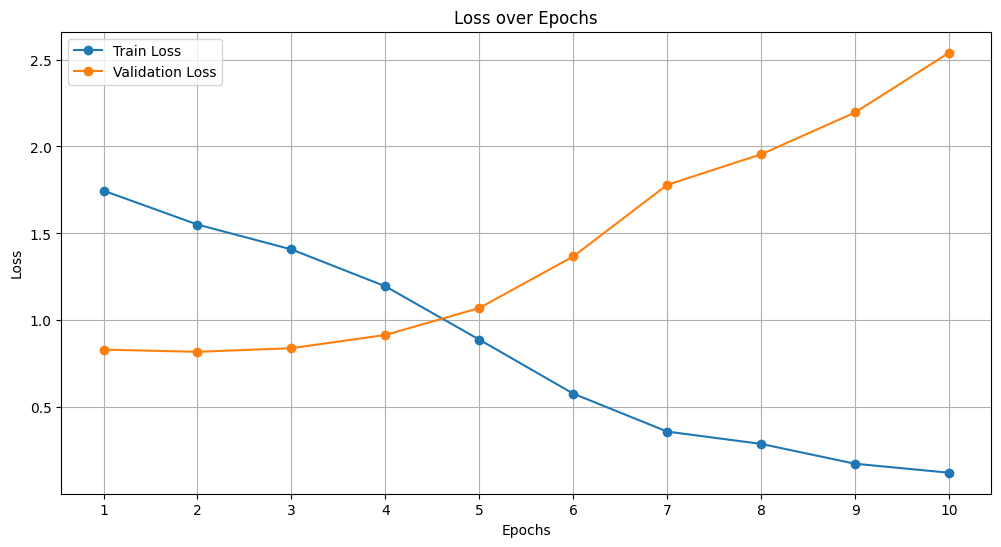

In [ ]:
epochs = list(range(1, N_EPOCHS + 1))

# Plot Loss
plot_metrics(epochs, Loss_Train.values(), Loss_val.values(), 'Loss')

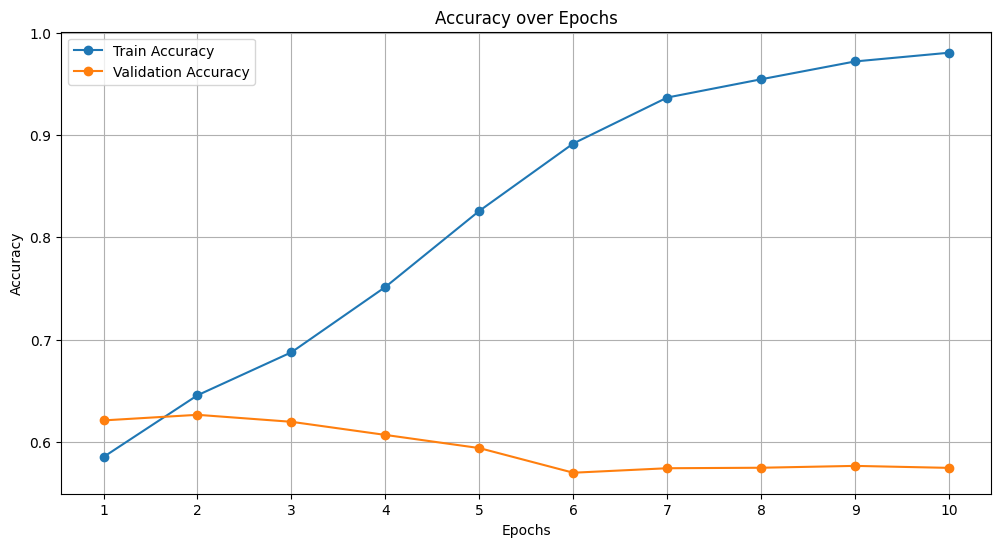

In [ ]:
plot_metrics(epochs, Accuracy_Train.values(), Accuracy_val.values(), 'Accuracy')

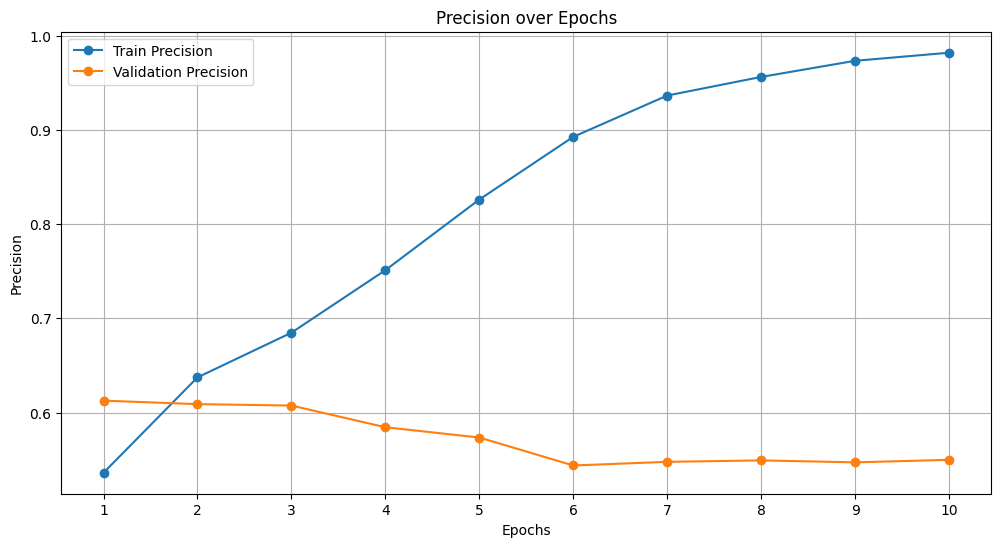

In [ ]:

plot_metrics(epochs, Precision_Train.values(), Precision_val.values(), 'Precision')


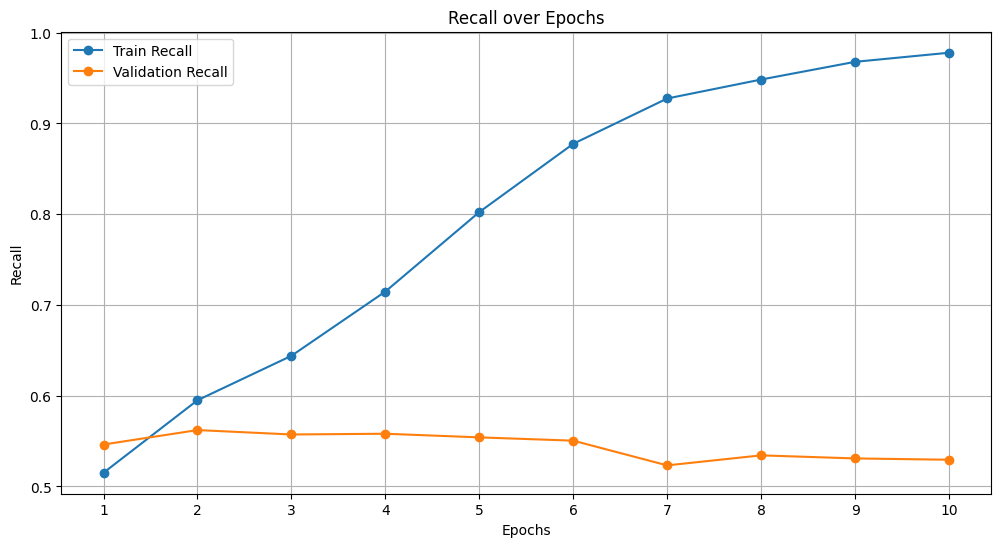

In [ ]:

plot_metrics(epochs, Recall_Train.values(), Recall_val.values(), 'Recall')

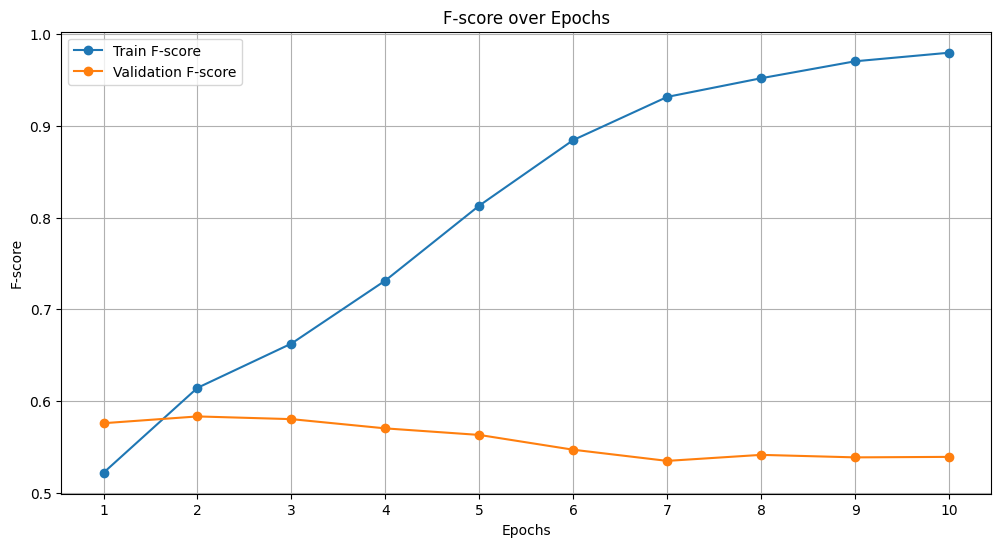

In [ ]:
plot_metrics(epochs, F_scores_Train.values(), F_scores_val.values(), 'F-score')

## **Testing :**

In [ ]:
model.load_state_dict(torch.load('ffn-model.pt'))
test_loss, test_acc, test_precision, test_recall, test_fscore = evaluate(model, test_iterator, criterion)
test_loss, test_acc, test_precision, test_recall, test_fscore = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% | Test Precision: {test_precision:.3f} | Test Recall: {test_recall:.3f} | Test F1-Score: {test_fscore:.3f}')



Test Loss: 0.731 | Test Acc: 68.08% | Test Precision: 0.699 | Test Recall: 0.624 | Test F1-Score: 0.658


<ipython-input-117-aff6a7772af1>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('ffn-model.pt'))
